## Follow the comment prompts to train a neural network

In [9]:
# very common imports
from math import floor
import numpy as np
import pandas as pd
from scipy.stats import pearsonr
import matplotlib.pyplot as plt

# common torch imports
import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
from torch.utils.data import DataLoader, TensorDataset, Dataset

# common sklearn imports 
from sklearn.model_selection import train_test_split

from zootopia3 import simulate_sinusoids

In [10]:
# we will not have a gpu accessible
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
if not torch.cuda.is_available():
    print("CUDA is NOT available to Pytorch")
print(device)

CUDA is NOT available to Pytorch
cpu


In [2]:
# set up simulation settings
num_each = 50
amplitudes = [0.5, 1, 2, 4]
frequencies = [0.5, 1, 2, 4, 8]
phases = [1, 2, 3, 4]
vertical_shifts = [-0.5, -0.25, 0, 0.25, 0.5]
length = 50

In [3]:
# simulate sinusoid data
Z = simulate_sinusoids(
    num_each,
    amplitudes,
    frequencies,
    phases,
    vertical_shifts,
    length
)
Z.shape

(20000, 50)

In [4]:
# how many time points forward to predict
# defines the dimensionality of the output
num_next_steps = 1

# split sine waves into predictor and target
X = Z[:,:-num_next_steps]
y = Z[:,-num_next_steps:]
X.shape, y.shape

((20000, 49), (20000, 1))

In [5]:
# TO DO
# perform the train test split
# so that we evaluate the model
# on held out data
# use this function
# https://scikit-learn.org/stable/modules/generated/sklearn.model_selection.train_test_split.html

X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size = 0.2, random_state=100395
)

# convert data to torch tensors
X_train = torch.tensor(X_train)
X_test = torch.tensor(X_test)
y_train = torch.tensor(y_train)
y_test = torch.tensor(y_test)

In [6]:
# set up the data loader
# which is so we update the model
# in batches

# Experiment with different batch sizes
batch_size = 2 ** 6

# Define the dataset loader as train_loader and test_loader
# https://docs.pytorch.org/docs/stable/data.html#torch.utils.data.DataLoader

train_data = TensorDataset(X_train, y_train)
test_data = TensorDataset(X_test, y_test)

train_loader = DataLoader(
    train_data,
    batch_size=batch_size,
    shuffle=True
)

test_loader = DataLoader(
    test_data,
    batch_size=batch_size,
    shuffle=False
)

### First, fit a multi-layer perceptron

In [7]:
# build a model class
# https://docs.pytorch.org/docs/stable/nn.html

class MyMLP(nn.Module):
    '''Multilayer perceptron to predict the next point in a sine wave'''

    def __init__(self, 
                input_dim, 
                output_dim, 
                num_layers, 
                hidden_dim, 
                dropout=0.2):
        '''
        Parameters
        ----------
        num_layers : int
            The depth of the neural network
        hidden_dim : int
            The height of the neural network
        dropout : int
            The dropout probability
        '''

        # must have this
        # inherits the internal attributes 
        # and methods of nn.Module
        # which is a lot of machinery
        # that we do not want to write
        # from scratch
        super(MyMLP, self).__init__()
        layers = []

        # What are the dimensions of the nn.Linear()
        layers.append(nn.Linear(input_dim, hidden_dim))
        layers.append(nn.BatchNorm1d(hidden_dim)) # play around without this
        layers.append(nn.ReLU())
        layers.append(nn.Dropout(dropout))

        for _ in range(num_layers):
            # Extended the layers list to have repeating blocks
            layers.append(nn.Linear(hidden_dim, hidden_dim))
            layers.append(nn.BatchNorm1d(hidden_dim)) # play around without this
            layers.append(nn.ReLU())
            layers.append(nn.Dropout(dropout))

        # What are the 
        layers.append(nn.Linear(hidden_dim, output_dim))
        
        self.block = nn.Sequential(*layers)
        
    # Usually, this method defines the computation graph
    # Telling us how to backpropagate the gradients
    # The nn.Sequential() class above already handles this
    def forward(self, x):
        return self.block(x)

In [11]:
num_layers = 3
hidden_dim = 8
dropout = 0.2

model = MyMLP(
    length - num_next_steps,
    num_next_steps,
    num_layers,
    hidden_dim,
    dropout = dropout
    # Specify the layers and hidden units
)

model.to(device) # important if using a gpu

# Assign a loss function to criterion
# https://docs.pytorch.org/docs/stable/nn.html#loss-functions
criterion = nn.MSELoss()

# define the optimizer
optimizer = optim.Adam(
    model.parameters(),
    lr=1e-4
)

model

MyMLP(
  (block): Sequential(
    (0): Linear(in_features=49, out_features=8, bias=True)
    (1): BatchNorm1d(8, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (2): ReLU()
    (3): Dropout(p=0.2, inplace=False)
    (4): Linear(in_features=8, out_features=8, bias=True)
    (5): BatchNorm1d(8, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (6): ReLU()
    (7): Dropout(p=0.2, inplace=False)
    (8): Linear(in_features=8, out_features=8, bias=True)
    (9): BatchNorm1d(8, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (10): ReLU()
    (11): Dropout(p=0.2, inplace=False)
    (12): Linear(in_features=8, out_features=8, bias=True)
    (13): BatchNorm1d(8, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (14): ReLU()
    (15): Dropout(p=0.2, inplace=False)
    (16): Linear(in_features=8, out_features=1, bias=True)
  )
)

In [12]:
# the number of parameters in different layers
[p.numel() for p in model.parameters()]

[392, 8, 8, 8, 64, 8, 8, 8, 64, 8, 8, 8, 64, 8, 8, 8, 8, 1]

In [13]:
# write the training loop

num_epochs = 30

train_losses = []
test_losses = []

for epoch in range(num_epochs):

    model.train() # very important
    running_loss = 0.
    for inputs, labels in train_loader:

        optimizer.zero_grad()
        
        # put on the gpu or cpu device
        inputs = inputs.to(device)
        labels = labels.to(device)
        
        # forward pass
        pred = model(inputs.float())

        # compute the loss
        loss = criterion(pred, labels)

        # backward pass
        # to change parameters
        loss.backward()
        optimizer.step()

        running_loss += loss.item()

    train_loss = running_loss / len(train_loader)
    train_losses.append(train_loss)

    print(f"Epoch {epoch+1}/{num_epochs}, Train Loss: {train_loss:.4f}")

Epoch 1/30, Train Loss: 2.8911
Epoch 2/30, Train Loss: 2.7109
Epoch 3/30, Train Loss: 2.5644
Epoch 4/30, Train Loss: 2.3961
Epoch 5/30, Train Loss: 2.1611
Epoch 6/30, Train Loss: 1.8926
Epoch 7/30, Train Loss: 1.6660
Epoch 8/30, Train Loss: 1.4719
Epoch 9/30, Train Loss: 1.2733
Epoch 10/30, Train Loss: 1.1181
Epoch 11/30, Train Loss: 1.0634
Epoch 12/30, Train Loss: 0.9908
Epoch 13/30, Train Loss: 0.9612
Epoch 14/30, Train Loss: 0.9314
Epoch 15/30, Train Loss: 0.9267
Epoch 16/30, Train Loss: 0.8809
Epoch 17/30, Train Loss: 0.8698
Epoch 18/30, Train Loss: 0.8287
Epoch 19/30, Train Loss: 0.8175
Epoch 20/30, Train Loss: 0.8325
Epoch 21/30, Train Loss: 0.7871
Epoch 22/30, Train Loss: 0.7665
Epoch 23/30, Train Loss: 0.7454
Epoch 24/30, Train Loss: 0.7493
Epoch 25/30, Train Loss: 0.7300
Epoch 26/30, Train Loss: 0.7212
Epoch 27/30, Train Loss: 0.7188
Epoch 28/30, Train Loss: 0.6935
Epoch 29/30, Train Loss: 0.6655
Epoch 30/30, Train Loss: 0.6711


### Evaluation

In [14]:
# predict on the held out data
model.eval() # important so that model is frozen!
with torch.no_grad():
    y_pred = model(X_test.float().contiguous())

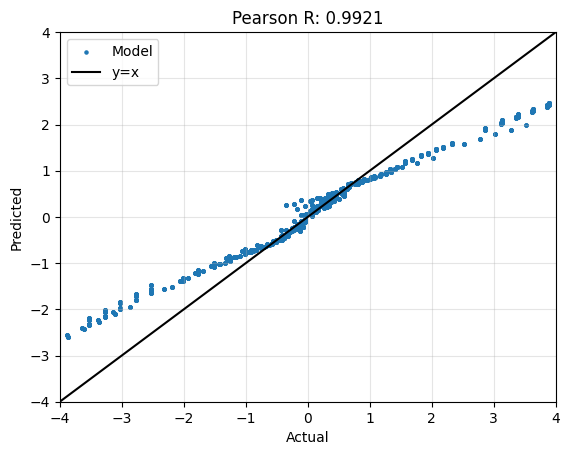

In [15]:
# visualization for continuous 1 dimensional data
dimension = 0
plt.scatter(y_test[:,dimension], y_pred[:,dimension], s=5, label='Model')
plt.xlabel('Actual')
plt.ylabel('Predicted')
plt.title(f'Pearson R: {pearsonr(y_test.squeeze(), y_pred.squeeze()).statistic:.4f}')
plt.grid(alpha=0.33)
plt.ylim(-4,4)
plt.xlim(-4,4)
plt.plot(np.linspace(-4,4,100), np.linspace(-4,4,100), color='k', label='y=x')
plt.legend()

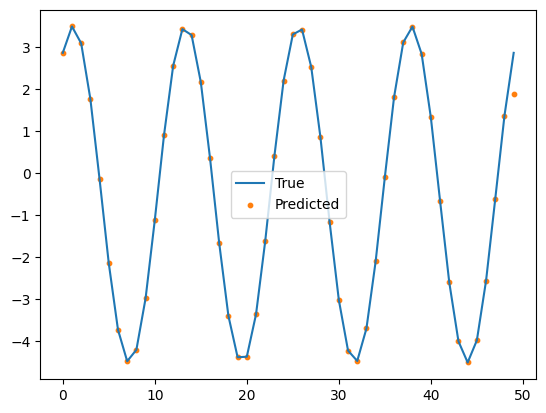

In [16]:
# visualization for multiple point inferences
idx = 600
plt.plot(torch.concatenate((X_test[idx], y_test[idx])), label='True')
plt.scatter(range(length), torch.concatenate((X_test[idx], y_pred[idx])), 
    s=10, 
    label='Predicted', 
    color='tab:orange'
)
plt.legend()

### Second, fit a recurrent neural network

We will walk through this one

In [ ]:
class MyRNN(nn.Module):
    '''Recurrent neural network to predict the next point in a sine wave'''

    def __init__(self, 
                    input_size, 
                    output_size, 
                    hidden_dim, 
                    class_=nn.RNN, 
                    num_layers=1,
                    dropout=0.2,
                    ):
        """Initialize the model

        Parameters
        ----------
        input_size : int
            Size of the input features.
        output_size : int
            Size of the output features.
        hidden_dim : int
            Size of the hidden state.
        num_layers : int
            Number of recurrent layers (default is 1).
        dropout : float
            Dropout probability for generalizability (default is 0.2)
        """
        super(MyRNN, self).__init__()

        self.num_layers = num_layers
        self.hidden_dim = hidden_dim

        # Define the RNN layer
        # class_ could be nn.RNN or nn.LSTM
        # may need to add cell state for LSTM version
        self.rnn = class_(input_size, hidden_dim, num_layers, dropout=dropout, batch_first=True)

        # Define the output layer
        self.fc = nn.Linear(hidden_dim, output_size)

    def forward(self, x, hidden):
        # Pass through RNN layer
        out, hidden = self.rnn(x, hidden)

        # Pass the output of the last time step to the fully connected layer
        out = self.fc(out[:, -1, :])
        return out, hidden

    def init_hidden(self, batch_size):
        # Initialize hidden state with zeros
        return torch.zeros(self.num_layers, batch_size, self.hidden_dim)

In [18]:
num_layers = 2
hidden_dim = 16
model = MyRNN(
    1,
    num_next_steps,
    hidden_dim,
    class_=nn.RNN,
    num_layers=num_layers,
    dropout=0.2,
)

model.to(device)

# define the loss function
criterion = nn.MSELoss()

# define the optimizer
optimizer = optim.Adam(
    model.parameters(),
    lr=1e-4
)

model

MyRNN(
  (rnn): RNN(1, 16, num_layers=2, batch_first=True, dropout=0.2)
  (fc): Linear(in_features=16, out_features=1, bias=True)
)

In [19]:
# the number of parameters in different layers
[p.numel() for p in model.parameters()]

[16, 256, 16, 16, 256, 256, 16, 16, 16, 1]

In [20]:
# write the training loop

num_epochs = 10

train_losses = []
test_losses = []

for epoch in range(num_epochs):

    model.train() # very important
    running_loss = 0.
    for inputs, labels in train_loader:

        optimizer.zero_grad()
        
        # put on the gpu or cpu device
        inputs = inputs.to(device)
        labels = labels.to(device)
        
        # forward pass
        inputs = inputs.unsqueeze(2)
        hidden = model.init_hidden(inputs.size(0))
        pred, hidden = model(inputs, hidden)

        # compute the loss
        loss = criterion(pred, labels)

        # backward pass
        # to change parameters
        loss.backward()
        optimizer.step()

        running_loss += loss.item()

    train_loss = running_loss / len(train_loader)
    train_losses.append(train_loss)

    print(f"Epoch {epoch+1}/{num_epochs}, Train Loss: {train_loss:.4f}")

Epoch 1/10, Train Loss: 2.4775
Epoch 2/10, Train Loss: 1.8458
Epoch 3/10, Train Loss: 1.3599
Epoch 4/10, Train Loss: 0.9418
Epoch 5/10, Train Loss: 0.6234
Epoch 6/10, Train Loss: 0.4309
Epoch 7/10, Train Loss: 0.3121
Epoch 8/10, Train Loss: 0.2473
Epoch 9/10, Train Loss: 0.2062
Epoch 10/10, Train Loss: 0.1727


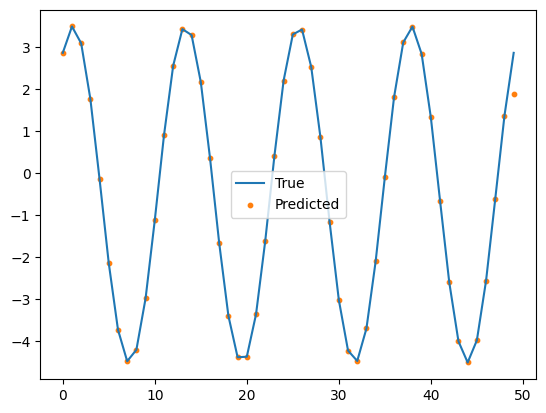

In [21]:
# visualization for multiple point inferences
idx = 600
plt.plot(torch.concatenate((X_test[idx], y_test[idx])), label='True')
plt.scatter(range(length), torch.concatenate((X_test[idx], y_pred[idx])), 
    s=10, 
    label='Predicted', 
    color='tab:orange'
)
plt.legend()

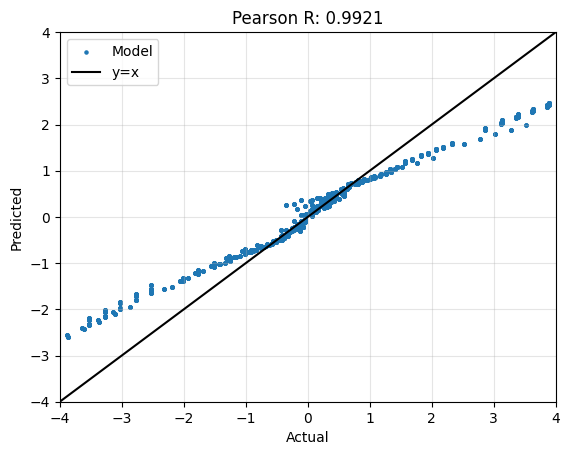

In [22]:
# visualization for continuous 1 dimensional data
dimension = 0
plt.scatter(y_test[:,dimension], y_pred[:,dimension], s=5, label='Model')
plt.xlabel('Actual')
plt.ylabel('Predicted')
plt.title(f'Pearson R: {pearsonr(y_test[:,0].squeeze(), y_pred[:,0].squeeze()).statistic:.4f}')
plt.grid(alpha=0.33)
plt.ylim(-4,4)
plt.xlim(-4,4)
plt.plot(np.linspace(-4,4,100), np.linspace(-4,4,100), color='k', label='y=x')
plt.legend()